# Honest Sampling
In this notebook, I will try to implement honest sampling in sklearn's random forest and hopefully this solves the overfitting problem in our conditional entropy estimate.

## Sampling Code

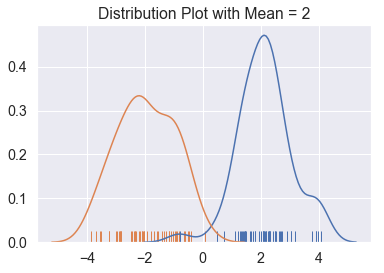

In [1]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.figure()
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 2")
plt.show()

In [8]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(2000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = None, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
        
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 200, .4)


0.6423980113137816

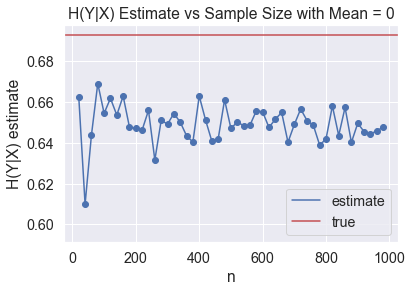

In [5]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .32))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

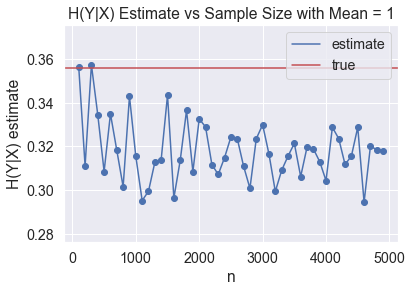

In [10]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*100 for i in range(1, 50)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .32))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

In [1]:
#TODO: do dimension tests

## Getting rid of bias
Here's an attempt to get rid of bias. For any pure node that you have, it is is all 0, set it to 1/2n, and if it 1, set it to 1-1/2n.  


In [4]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(5000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 20, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .32)


0.6925181258282529

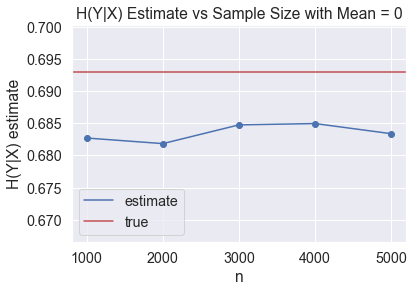

In [5]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*1000 for i in range(1, 6)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 5000, .32))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

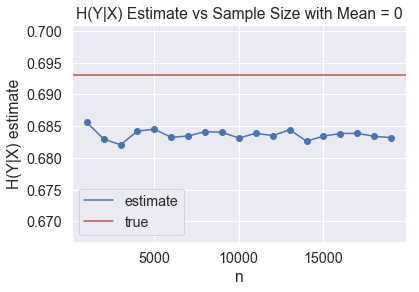

In [4]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*1000 for i in range(1, 20)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 1000, .32))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

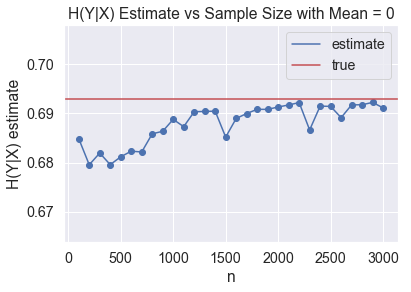

In [23]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*100 for i in range(1, 31)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 20))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

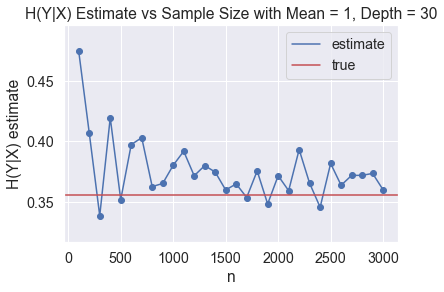

In [4]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*100 for i in range(1, 51)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1, Depth = 30")
plt.show()

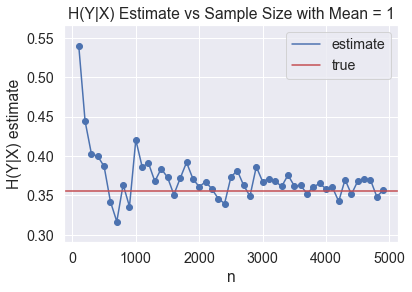

In [53]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

# Prune last level of tree

In [6]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(10000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = None, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in tqdm_notebook(model):
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        #posterior_true = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            decision_path = np.nonzero(tree.decision_path(X[prob_index].item()).toarray())
            node_before_leaf = decision_path[1][-2]
            posterior_class_counts[node_before_leaf, y[prob_index]] += 1
            #posterior_true[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        #print(posterior_class_counts)
        #print(posterior_true)
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        nodes_before_leaf_eval = get_node_idx_before_leaf(tree, X, eval_indices)
        partition_counts = np.asarray([node_counts[x] for x in nodes_before_leaf_eval])
        # get probability for out of bag samples            
        eval_class_probs = [class_probs[x] for x in nodes_before_leaf_eval]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

def get_node_idx_before_leaf(tree, X, indices):
    before_leaf = []
    for idx in indices:
        decision_path = np.nonzero(tree.decision_path(X[idx].item()).toarray())
        before_leaf.append(decision_path[1][-2])
    return before_leaf

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 1000, .32)


0.6798590432193813

In [12]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(2000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = False, depth = None, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        sampled_indices = [i for i in range(len(X)) if i not in unsampled_indices]
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for index in sampled_indices:
            decision_path = np.nonzero(tree.decision_path(X[index].item()).toarray())
            node_before_leaf = decision_path[1][-2]
            posterior_class_counts[node_before_leaf, y[index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        nodes_before_leaf_eval = get_node_idx_before_leaf(tree, X, unsampled_indices)
        partition_counts = np.asarray([node_counts[x] for x in nodes_before_leaf_eval])
        # get probability for out of bag samples            
        eval_class_probs = [class_probs[x] for x in nodes_before_leaf_eval]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
        
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

def get_node_idx_before_leaf(tree, X, indices):
    before_leaf = []
    for idx in indices:
        decision_path = np.nonzero(tree.decision_path(X[idx].item()).toarray())
        before_leaf.append(decision_path[1][-2])
    return before_leaf

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 200, .63)


0.6361619223613102